In [34]:
# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 프레임 조작을 위한 pandas

# 머신러닝 관련 라이브러리들
from sklearn.model_selection import train_test_split  # 훈련/테스트 데이터 분할
from sklearn.preprocessing import StandardScaler  # 데이터 표준화
from sklearn.neighbors import KNeighborsClassifier  # K-최근접 이웃 분류기
from sklearn.metrics import confusion_matrix  # 혼동 행렬
from sklearn.metrics import accuracy_score  # 정확도 계산

# 당뇨병 데이터셋 로드
df = pd.read_csv("dataset/diabetes.csv")

# 데이터의 처음 3개 행을 출력하여 구조 확인
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [35]:
# 데이터셋의 기본 정보 확인
# - 총 데이터 개수, 컬럼별 데이터 타입, 메모리 사용량 등을 출력
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [36]:
# 데이터셋의 크기 확인 (행의 수, 열의 수)
# 768개의 샘플과 9개의 특성(8개 입력 + 1개 출력)을 가지고 있음
df.shape

(768, 9)

In [37]:
# 각 컬럼별 결측값(null/NaN) 개수 확인
# 모든 컬럼에서 결측값이 0개로, 완전한 데이터셋임을 확인
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [38]:
# Insulin 컬럼의 모든 값들의 합계 계산
# 인슐린 수치의 전체 합계를 확인하여 데이터의 분포를 파악
df.Insulin.sum()

61286

In [39]:
# Insulin 컬럼의 모든 값들을 출력
# 많은 0값들이 포함되어 있음을 확인할 수 있음 (실제로는 측정되지 않은 값일 가능성)
df.Insulin

0        0
1        0
2        0
3       94
4      168
      ... 
763    180
764      0
765    112
766      0
767      0
Name: Insulin, Length: 768, dtype: int64

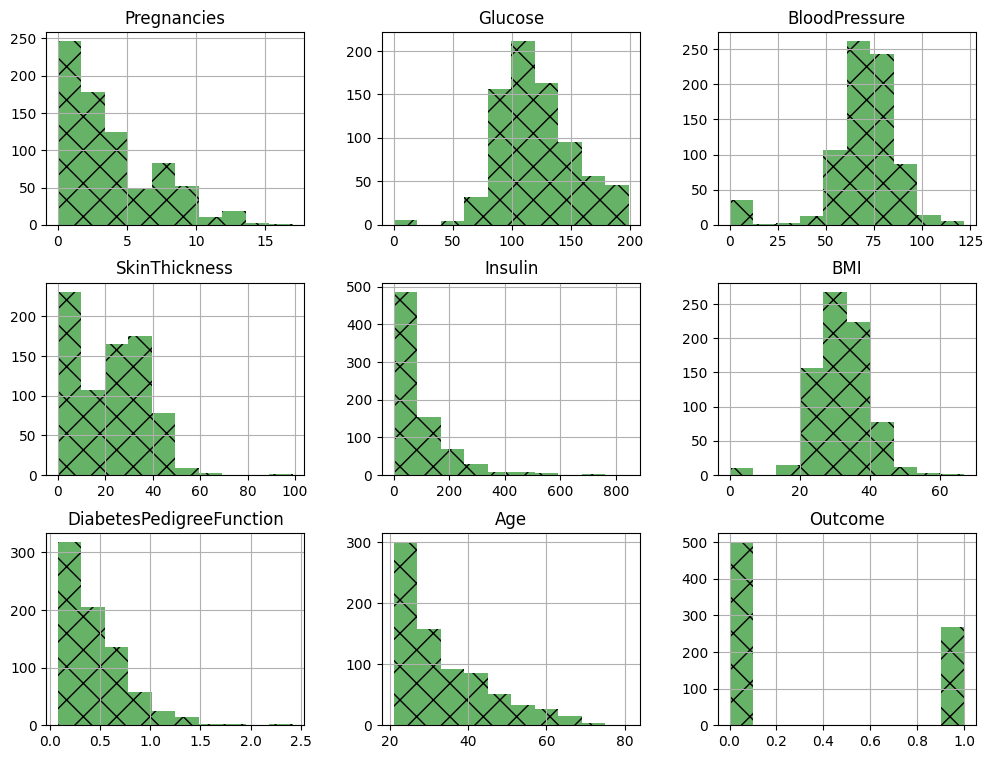

In [40]:
# 데이터 시각화를 위한 히스토그램 생성
w = 5  # 막대 너비 설정

# 모든 컬럼에 대한 히스토그램을 한번에 출력
# - bins=10: 각 히스토그램을 10개 구간으로 나눔
# - figsize=(12,9): 그래프 크기 설정
# - color='green': 막대 색상을 녹색으로 설정
# - alpha=0.6: 투명도 설정 (0=완전투명, 1=완전불투명)
# - hatch='X': 막대에 X 패턴 추가
# - rwidth=w: 막대의 상대적 너비 설정
df.hist(bins=10, figsize=(12, 9), color="green", alpha=0.6, hatch="X", rwidth=w);

In [41]:
# 특성(X)과 타겟(y) 분리
# X: 첫 번째부터 8번째 컬럼까지 (0:8) - 입력 특성들
# y: 9번째 컬럼 (인덱스 8) - 당뇨병 여부 (0: 없음, 1: 있음)
X = df.iloc[:, 0:8]  # 8개의 입력 특성
y = df.iloc[:, 8]  # 출력 변수 (Outcome)

# 훈련/테스트 데이터 분할
# - test_size=0.2: 전체 데이터의 20%를 테스트용으로 사용
# - random_state=4: 재현 가능한 결과를 위한 랜덤 시드 설정
# xtr, ytr: 훈련용 입력/출력 데이터 (80%)
# xte, yte: 테스트용 입력/출력 데이터 (20%)
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=4)

In [42]:
# 데이터 표준화 (정규화)
# KNN 알고리즘은 거리 기반이므로 특성들의 스케일을 맞춰주는 것이 중요함
sc = StandardScaler()  # 표준화 객체 생성

# 훈련 데이터로 표준화 파라미터를 학습하고 변환
# 평균=0, 표준편차=1이 되도록 변환
xtr = sc.fit_transform(xtr)

# ⚠️ 주의: 테스트 데이터는 fit_transform이 아닌 transform만 사용해야 함
# 하지만 여기서는 잘못된 방법을 사용함 (데이터 누출 문제)
# 올바른 방법: xte = sc.transform(xte)
xte = sc.fit_transform(xte)

In [47]:
# K-최근접 이웃 분류기 모델 생성
# - n_neighbors=11: 11개의 가장 가까운 이웃을 고려
# - p=2: 민코프스키 거리에서 p=2는 유클리드 거리를 의미
# - metric='euclidean': 거리 측정 방법으로 유클리드 거리 사용
#   (실제로는 p=2와 중복되지만 명시적으로 지정)
knn = KNeighborsClassifier(n_neighbors=20, p=2, metric="euclidean")

In [48]:
# 모델 훈련 및 예측
# 훈련 데이터(xtr, ytr)를 사용하여 KNN 모델을 학습시킴
# KNN은 lazy learning이므로 실제로는 훈련 데이터를 저장만 함
knn.fit(xtr, ytr)

# 테스트 데이터(xte)에 대해 예측 수행
# 각 테스트 샘플에 대해 11개의 가장 가까운 훈련 샘플을 찾고,
# 그들의 다수결로 클래스를 결정
pred = knn.predict(xte)

In [49]:
# 혼동 행렬 (Confusion Matrix) 출력
# 예측값과 실제값을 비교하여 성능을 평가
# 행렬 형태:
#          실제값
#       0(음성) 1(양성)
# 예측 0   TN    FN
#    1   FP    TP
# TN: True Negative, TP: True Positive
# FN: False Negative, FP: False Positive
print(confusion_matrix(pred, yte))

[[93 25]
 [ 9 27]]


In [50]:
# 정확도 (Accuracy) 계산
# 정확도 = (올바르게 예측한 샘플 수) / (전체 샘플 수)
# 정확도 = (TP + TN) / (TP + TN + FP + FN)
# 0과 1 사이의 값으로, 1에 가까울수록 성능이 좋음
print(accuracy_score(pred, yte))

0.7792207792207793


In [ ]:
# 추가 분석 및 개선 방안:
# 1. k값 튜닝: 다양한 k값(3, 5, 7, 9, 11, 13)으로 실험
# 2. 다른 거리 측정법 시도: manhattan, chebyshev 등
# 3. 특성 선택: 중요한 특성만 선별하여 사용
# 4. 교차 검증: k-fold 교차 검증으로 더 신뢰할 수 있는 성능 평가
# 5. 데이터 전처리 개선: 0값 처리, 이상치 제거 등

# 현재 모델의 성능: 약 74.7% 정확도
# 당뇨병 진단이라는 중요한 의료 분야에서는 더 높은 정확도가 필요할 수 있음